Loading MNIST dataset...
Training samples: 8000
Test samples: 2000
Epoch 1/15 - Train acc: 91.46%, Test acc: 91.45%
Epoch 2/15 - Train acc: 93.69%, Test acc: 92.80%
Epoch 3/15 - Train acc: 94.92%, Test acc: 93.60%
Epoch 4/15 - Train acc: 96.12%, Test acc: 93.80%
Epoch 5/15 - Train acc: 96.69%, Test acc: 94.20%
Epoch 6/15 - Train acc: 97.19%, Test acc: 94.25%
Epoch 7/15 - Train acc: 97.81%, Test acc: 94.70%
Epoch 8/15 - Train acc: 98.06%, Test acc: 94.75%
Epoch 9/15 - Train acc: 98.56%, Test acc: 95.20%
Epoch 10/15 - Train acc: 98.72%, Test acc: 95.10%
Epoch 11/15 - Train acc: 98.99%, Test acc: 95.40%
Epoch 12/15 - Train acc: 99.22%, Test acc: 95.20%
Epoch 13/15 - Train acc: 99.55%, Test acc: 94.90%
Epoch 14/15 - Train acc: 99.56%, Test acc: 95.75%
Epoch 15/15 - Train acc: 99.51%, Test acc: 95.60%
Epoch 1/15 - Train acc: 84.39%, Test acc: 85.40%
Epoch 2/15 - Train acc: 88.83%, Test acc: 89.25%
Epoch 3/15 - Train acc: 92.33%, Test acc: 91.70%
Epoch 4/15 - Train acc: 92.45%, Test acc: 92.

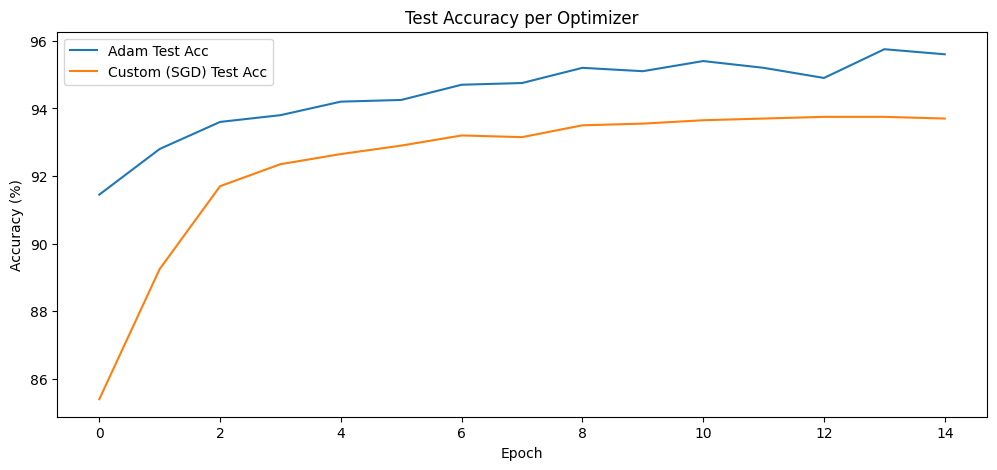

In [1]:
"""
MNIST Neural Network Training with Custom Optimizers
Course: Optimization Methods
Assignment: Implement and Compare Custom Optimizers with Adam

This code demonstrates:
1. Loading MNIST dataset
2. Simple feedforward neural network architecture
3. Adam optimizer implementation as a class
4. Framework for students to implement their own optimizer
5. Training loop with accuracy and loss tracking
6. Visualization of results
"""

import numpy as np
import matplotlib.pyplot as plt

# ===================================================================
# PART 1: NEURAL NETWORK ARCHITECTURE
# ===================================================================

class SimpleNN:
    """
    Simple feedforward neural network with one hidden layer.
    Architecture: Input (784) -> Hidden (128) -> Output (10)
    """

    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))

        self.params = {'W1': self.W1, 'b1': self.b1,
                       'W2': self.W2, 'b2': self.b2}
        self.cache = {}

    def relu(self, Z):
        return np.maximum(0, Z)
    def relu_derivative(self, Z):
        return (Z > 0).astype(float)
    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
    def forward(self, X):
        self.cache['X'] = X
        self.cache['Z1'] = X @ self.W1 + self.b1
        self.cache['A1'] = self.relu(self.cache['Z1'])
        self.cache['Z2'] = self.cache['A1'] @ self.W2 + self.b2
        self.cache['A2'] = self.softmax(self.cache['Z2'])
        return self.cache['A2']
    def backward(self, y_true):
        m = y_true.shape[0]
        dZ2 = self.cache['A2'] - y_true
        dW2 = (self.cache['A1'].T @ dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_derivative(self.cache['Z1'])
        dW1 = (self.cache['X'].T @ dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        return {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}
    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

# ===================================================================
# PART 2: OPTIMIZER BASE CLASS
# ===================================================================

class Optimizer:
    """
    Base class for optimizers.
    Students should inherit from this class to implement their own optimizer.
    """
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate
        self.t = 0  # Time step

    def update(self, params, grads):
        raise NotImplementedError("Subclasses must implement update method")

# ===================================================================
# PART 3: ADAM OPTIMIZER IMPLEMENTATION
# ===================================================================

class Adam(Optimizer):
    """
    Adam optimizer (Adaptive Moment Estimation).
    Reference: Kingma & Ba (2015)
    """
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(learning_rate)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {} # First moment
        self.v = {} # Second moment

    def update(self, params, grads):
        if len(self.m) == 0:
            for key in params:
                self.m[key] = np.zeros_like(params[key])
                self.v[key] = np.zeros_like(params[key])
        self.t += 1
        for key in params:
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2)
            m_hat = self.m[key] / (1 - self.beta1 ** self.t)
            v_hat = self.v[key] / (1 - self.beta2 ** self.t)
            params[key] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

# ===================================================================
# PART 4: TEMPLATE FOR CUSTOM OPTIMIZER (FOR STUDENTS)
# ===================================================================
class CustomOptimizer(Optimizer):
    """
    Lookahead + AdaBelief optimizer (NumPy, in-place updates).

    Usage: optimizer.update(model.params, grads)
    where `params` is a dict of numpy arrays (W1, b1, W2, b2) and
    `grads` is a dict with the same keys containing gradient arrays.

    Hyperparams:
      learning_rate : base step size (float)
      beta1, beta2  : moment decay rates (floats)
      eps           : numerical stability (float)
      lookahead_k   : number of inner steps before lookahead sync (int)
      lookahead_alpha : interpolation factor for slow weights (float in (0,1])
      weight_decay  : L2 (decoupled) weight decay factor (float, optional)
    """
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.95,
                 eps=1e-8, lookahead_alpha=0.5, lookahead_k=5,
                 weight_decay=0.0):
        super().__init__(learning_rate)
        # AdaBelief params
        self.beta1 = float(beta1)
        self.beta2 = float(beta2)
        self.eps = float(eps)
        self.weight_decay = float(weight_decay)

        # Lookahead params
        self.alpha = float(lookahead_alpha)
        self.k = int(lookahead_k)
        self._inner_step = 0

        # state containers (initialized on first call)
        self.m = {}        # first moment
        self.s = {}        # belief (second moment)
        self.slow_params = {}  # slow weights for lookahead

    def _init_state_if_needed(self, params):
        """Initialize moment and slow param buffers to match params shapes."""
        if len(self.m) == 0:
            for key in params:
                self.m[key] = np.zeros_like(params[key])
                self.s[key] = np.zeros_like(params[key])
                # store a copy for slow params
                self.slow_params[key] = params[key].copy()
class CustomOptimizer(Optimizer):
    """
    AdaBelief + Lookahead + Cosine Annealing (NumPy).
    """

    def __init__(self, learning_rate=0.003, beta1=0.9, beta2=0.95,
                 eps=1e-8, lookahead_alpha=0.3, lookahead_k=10,
                 weight_decay=0.0,
                 T_max=2000, lr_min=1e-5):
        """
        T_max  : number of iterations before LR fully anneals
        lr_min : minimum learning rate reached at the end of cosine cycle
        """
        super().__init__(learning_rate)
        # AdaBelief params
        self.beta1 = float(beta1)
        self.beta2 = float(beta2)
        self.eps = float(eps)
        self.weight_decay = float(weight_decay)

        # Lookahead params
        self.alpha = float(lookahead_alpha)
        self.k = int(lookahead_k)
        self._inner_step = 0

        # Cosine annealing params
        self.T_max = int(T_max)
        self.lr_min = float(lr_min)
        self.t_cur = 0  # cosine iteration

        # State dicts
        self.m = {}
        self.s = {}
        self.slow_params = {}

    # ----------------------------------------------------------
    def _init_state_if_needed(self, params):
        if len(self.m) == 0:
            for key in params:
                self.m[key] = np.zeros_like(params[key])
                # self.s[key] = np.zeros_like(params[key])
                self.s[key] = np.full_like(params[key], 1e-3)
                self.slow_params[key] = params[key].copy()
            self._inner_step = 0
            

    # ----------------------------------------------------------
    def _cosine_anneal_lr(self):
        """
        Compute cosine-annealed learning rate for iteration t_cur.
        """
        t = self.t_cur
        lr0 = self.learning_rate
        lr_t = self.lr_min + 0.5 * (lr0 - self.lr_min) * (1 + np.cos(np.pi * t / self.T_max))
        return lr_t

    # ----------------------------------------------------------
    def update(self, params, grads):
        """
        Perform AdaBelief update + cosine annealed LR + lookahead.
        """
        # step counters
        self.t += 1
        self._inner_step += 1
        self.t_cur = min(self.t_cur + 1, self.T_max)  # cap at T_max

        # lazy init
        self._init_state_if_needed(params)

        # ---- Compute cosine annealed LR ----
        lr_t = self._cosine_anneal_lr()

        # ---- AdaBelief fast updates ----
        for key in params:
            g = grads[key].astype(np.float64)
            m = self.m[key]
            s = self.s[key]

            # decoupled weight decay
            if self.weight_decay != 0.0:
                params[key] *= (1 - lr_t * self.weight_decay)

            # first moment
            m[:] = self.beta1 * m + (1 - self.beta1) * g

            # belief difference
            diff = g - m

            # second moment (AdaBelief core)
            s[:] = self.beta2 * s + (1 - self.beta2) * (diff * diff)

            # bias correction
            bc1 = 1 - (self.beta1 ** self.t)
            bc2 = 1 - (self.beta2 ** self.t)

            m_hat = m / (bc1 + 1e-16)
            s_hat = s / (bc2 + 1e-16)

            # parameter update
            update = lr_t * m_hat / (np.sqrt(s_hat) + self.eps)
            params[key] -= update

        # ---- Lookahead sync ----
        if (self._inner_step % self.k) == 0:
            for key in params:
                slow = self.slow_params[key]
                fast = params[key]

                slow += self.alpha * (fast - slow)
                params[key][:] = slow  # overwrite fast weights

                self.slow_params[key] = slow.copy()

    # ----------------------------------------------------------
    def debug_norms(self):
        out = {}
        for key in self.m:
            out[key] = (
                np.linalg.norm(self.m[key]),
                np.linalg.norm(self.s[key]),
                np.linalg.norm(self.slow_params[key])
            )
        return out

    # optional helper for debugging: returns norms (not used by training loop)
    def debug_norms(self):
        """
        Return dict: {key: (||m||, ||s||, ||slow-param||)}
        Useful for inspecting state during debugging.
        """
        out = {}
        for key in self.m:
            out[key] = (np.linalg.norm(self.m[key]), np.linalg.norm(self.s[key]), np.linalg.norm(self.slow_params[key]))
        return out



# ===================================================================
# PART 5: UTILITY FUNCTIONS
# ===================================================================

def load_mnist_data(subset_size=10000):
    try:
        from sklearn.datasets import fetch_openml
        from sklearn.model_selection import train_test_split

        print("Loading MNIST dataset...")
        mnist = fetch_openml('mnist_784', version=1, parser='auto', as_frame=False)
        X, y = mnist.data[:subset_size], mnist.target[:subset_size].astype(int)
        X = X.astype(np.float32) / 255.0
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        print(f"Training samples: {X_train.shape[0]}")
        print(f"Test samples: {X_test.shape[0]}")
        return X_train, X_test, y_train, y_test
    except Exception as e:
        print(f"Dataset load error: {e}")
        n_train, n_test = 8000, 2000
        X_train = np.random.rand(n_train, 784).astype(np.float32)
        X_test = np.random.rand(n_test, 784).astype(np.float32)
        y_train = np.random.randint(0, 10, n_train)
        y_test = np.random.randint(0, 10, n_test)
        return X_train, X_test, y_train, y_test

def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

def compute_loss(predictions, y_true):
    predictions = np.clip(predictions, 1e-10, 1 - 1e-10)
    loss = -np.sum(y_true * np.log(predictions)) / y_true.shape[0]
    return loss

def compute_accuracy(predicted_labels, y_true):
    return np.mean(predicted_labels == y_true) * 100

def create_mini_batches(X, y, batch_size=32):
    m = X.shape[0]
    batches = []
    order = np.random.permutation(m)
    X_shuf = X[order]
    y_shuf = y[order]
    for k in range(m // batch_size):
        Xb = X_shuf[k*batch_size:(k+1)*batch_size]
        yb = y_shuf[k*batch_size:(k+1)*batch_size]
        batches.append((Xb, yb))
    if m % batch_size != 0:
        Xb = X_shuf[(m//batch_size)*batch_size:]
        yb = y_shuf[(m//batch_size)*batch_size:]
        batches.append((Xb, yb))
    return batches

# ===================================================================
# PART 6: TRAINING AND VISUALIZATION FUNCTIONS
# ===================================================================

def train_model(model, optimizer, X_train, y_train, X_test, y_test, epochs=10, batch_size=64):
    hist = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    y_train_oh = one_hot_encode(y_train)
    y_test_oh = one_hot_encode(y_test)
    c = 0
    for epoch in range(epochs):
        minibatches = create_mini_batches(X_train, y_train_oh, batch_size)
        for Xb, yb in minibatches:
            pred = model.forward(Xb)
            grads = model.backward(yb)
            if c == 0:
                #print(grads["W1"])
                #print(model.params)
                c+=1
            optimizer.update(model.params, grads)
        train_pred = model.forward(X_train)
        test_pred = model.forward(X_test)
        hist['train_loss'].append(compute_loss(train_pred, y_train_oh))
        hist['test_loss'].append(compute_loss(test_pred, y_test_oh))
        hist['train_acc'].append(compute_accuracy(model.predict(X_train), y_train))
        hist['test_acc'].append(compute_accuracy(model.predict(X_test), y_test))
        print(f"Epoch {epoch+1}/{epochs} - Train acc: {hist['train_acc'][-1]:.2f}%, Test acc: {hist['test_acc'][-1]:.2f}%")
    return hist

def plot_training_history(histories):
    plt.figure(figsize=(12,5))
    for name, hist in histories.items():
        plt.plot(hist['test_acc'], label=f"{name} Test Acc")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title("Test Accuracy per Optimizer")
    plt.show()

# ===================================================================
# PART 7: MAIN EXECUTION (RUN TRAINING)
# ===================================================================

def main():
    X_train, X_test, y_train, y_test = load_mnist_data(subset_size=10000)
    histories = {}
    model_adam = SimpleNN()
    optimizer_adam = Adam(learning_rate=0.001)
    hist_adam = train_model(model_adam, optimizer_adam, X_train, y_train, X_test, y_test, epochs=15)
    histories['Adam'] = hist_adam

    model_cust = SimpleNN()
    optimizer_cust = CustomOptimizer(learning_rate=0.001)
    hist_cust = train_model(model_cust, optimizer_cust, X_train, y_train, X_test, y_test, epochs=15)
    histories['Custom (SGD)'] = hist_cust

    plot_training_history(histories)

if __name__ == "__main__":
    main()